In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import torch

In [2]:
num_epochs = 21

In [3]:
# Get latest checkpoint
def get_latest_checkpoint(model_dir):
    # Verify if checkpoints are present
    checkpoint_files = glob.glob(os.path.join(model_dir, "epoch_*.pth"))
    if not checkpoint_files:
        return None, 0

    # Extract epoch numbers from filenames
    epochs = [int(os.path.basename(f).split("_")[1].split(".")[0]) for f in checkpoint_files]
    last_epoch = max(epochs)
    return os.path.join(model_dir, f"epoch_{last_epoch}.pth"), last_epoch

latest_checkpoint, last_epoch = get_latest_checkpoint("models")

In [4]:
# Load latest checkpoint
checkpoint = torch.load(latest_checkpoint, weights_only = False) 

batch_train_losses = checkpoint['batch_train_losses']
batch_test_losses = checkpoint['batch_test_losses']
epoch_train_losses = checkpoint['epoch_train_losses']
epoch_test_losses = checkpoint['epoch_test_losses']
batch_train_accuracy = checkpoint['batch_train_accuracy']
batch_test_accuracy = checkpoint['batch_test_accuracy']
epoch_train_accuracy = checkpoint['epoch_train_accuracy']
accuracies = checkpoint['accuracies']
classif_errors = checkpoint['classif_errors']
batch_times_train = checkpoint['batch_times_train']
batch_times_test = checkpoint['batch_times_test']
epoch_times = checkpoint['epoch_times']

In [5]:
print(f"Average computation time for training batches: {np.mean(batch_times_train):.2f} seconds")
print(f"Average computation time for validation batches: {np.mean(batch_times_test):.2f} seconds")
print(f"Average computation time per epoch: {np.mean(epoch_times)/3600:.2f} hours")
print(f"Total computation time: {np.sum(epoch_times)/3600:.2f} hours")

Average computation time for training batches: 20.29 seconds
Average computation time for validation batches: 26.90 seconds
Average computation time per epoch: 1.03 hours
Total computation time: 20.70 hours


# Learning curves

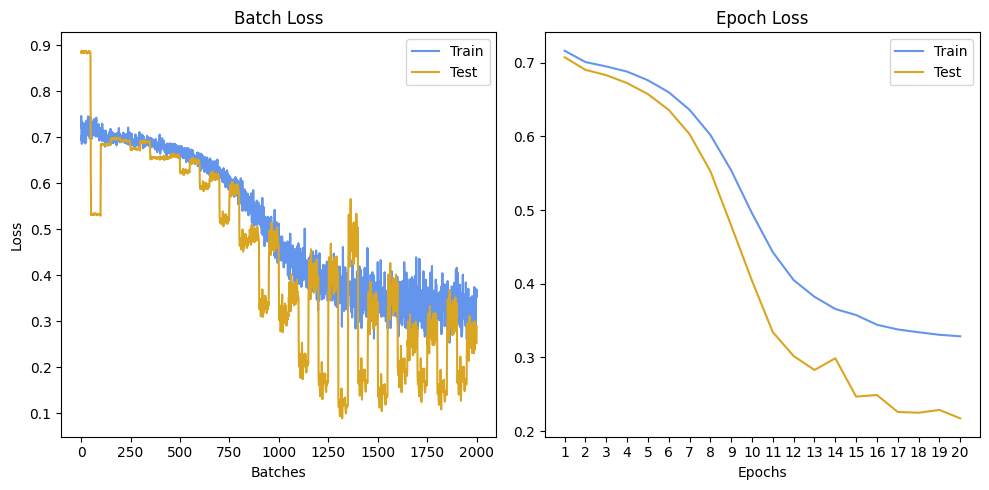

In [6]:
plt.figure(figsize=(10, 5))

# Plot batch loss
plt.subplot(1, 2, 1)
plt.plot(batch_train_losses, label='Train', color='cornflowerblue')
test_x = np.linspace(0, len(batch_train_losses) - 1, len(batch_test_losses))  # Match the scale for longer test batches
plt.plot(test_x, batch_test_losses, label='Test', color='goldenrod')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.title('Batch Loss')
plt.legend()

# Plot epoch loss
plt.subplot(1, 2, 2)
plt.plot(np.arange(1, len(epoch_train_losses) + 1), epoch_train_losses, label='Train', color='cornflowerblue')
plt.plot(np.arange(1, len(epoch_test_losses) + 1), epoch_test_losses, label='Test', color='goldenrod')
plt.xticks(np.arange(1, len(epoch_train_losses) + 1))
plt.xlabel('Epochs')
plt.ylabel('')
plt.title('Epoch Loss')
plt.legend()

# Show plot
plt.tight_layout()
plt.savefig("RoBERTa_learning_curves_1.png", dpi=300, bbox_inches='tight')
plt.show()

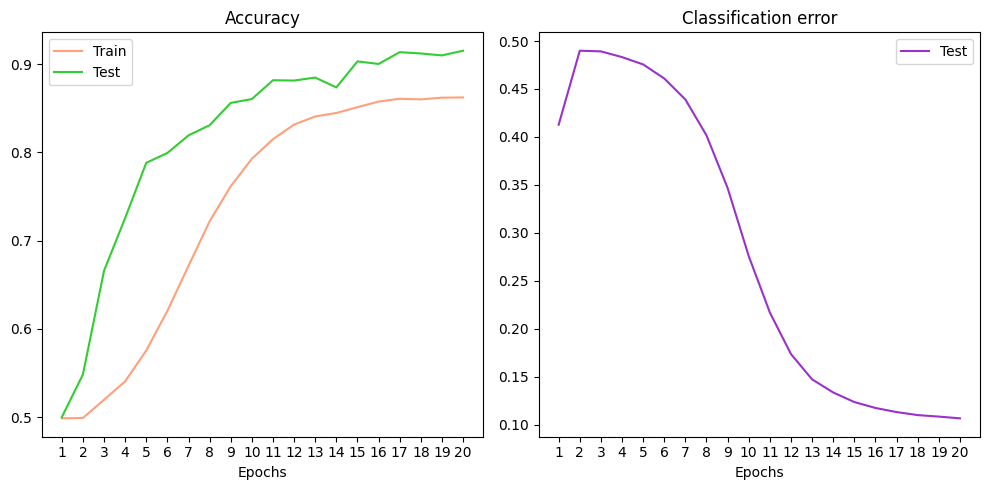

In [7]:
plt.figure(figsize=(10, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, len(epoch_train_accuracy) + 1), epoch_train_accuracy, label='Train', color='lightsalmon')
plt.plot(np.arange(1, len(accuracies) + 1), accuracies, label='Test', color='limegreen')
plt.xticks(np.arange(1, len(accuracies) + 1))
plt.xlabel('Epochs')
plt.title('Accuracy')
plt.legend()

# Plot classification error
plt.subplot(1, 2, 2)
plt.plot(np.arange(1, len(classif_errors) + 1), classif_errors, label='Test', color='darkorchid')
plt.xticks(np.arange(1, len(classif_errors) + 1))
plt.xlabel('Epochs')
plt.title('Classification error')
plt.legend()

# Show plot
plt.tight_layout()
plt.savefig("RoBERTa_learning_curves_2.png", dpi=300, bbox_inches='tight')
plt.show()

In [8]:
(pd.DataFrame([accuracies, classif_errors]).T
 .rename(columns={0: 'Accuracy', 1: 'Classification error'})
 .assign(Epochs=lambda df: df.index + 1)
 .loc[:, ['Epochs', 'Accuracy', 'Classification error']]
 .style
 .hide(axis='index'))

Epochs,Accuracy,Classification error
1,0.500000,0.412715
2,0.548360,0.489891
3,0.665840,0.489200
4,0.725680,0.483233
5,0.788200,0.475588
6,0.799360,0.460937
7,0.819280,0.438991
8,0.830800,0.401606
9,0.856080,0.346734
10,0.860440,0.275688


# Best model

In [9]:
# Select the model with the highest accuracy
best_epoch = accuracies.index(max(accuracies)) + 1
print(f"Best epoch: {best_epoch}")
print(f"Accuracy: {accuracies[best_epoch-1]}")

Best epoch: 20
Accuracy: 0.9152


In [10]:
# Load predicted sentiments
results = pd.read_csv(f"preds/epoch_{best_epoch}.csv")

In [11]:
print(f"Number of ties: {(results['prob_class_0'] == results['prob_class_1']).sum()}")

Number of ties: 0


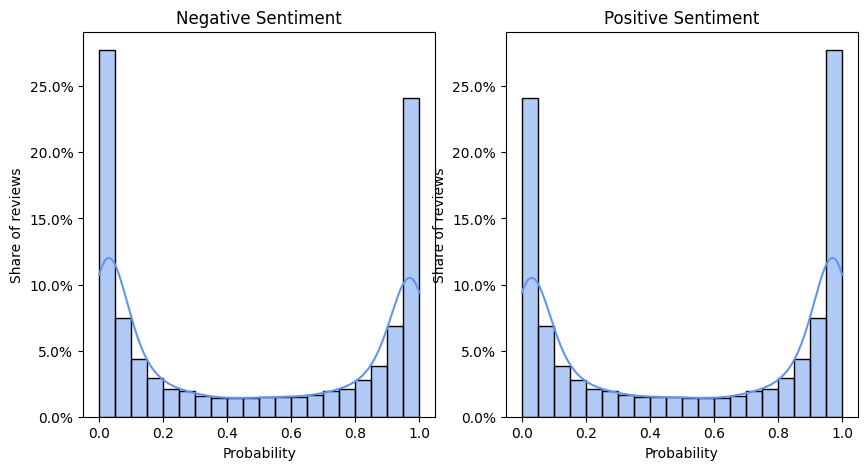

In [12]:
# Distribution of predicted probabilities
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.histplot(results['prob_class_0'], bins=20, color="cornflowerblue", kde=True, stat="probability")
plt.xlabel("Probability")
plt.ylabel("Share of reviews")
plt.title("Negative Sentiment")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x * 100:.1f}%'))

plt.subplot(1, 2, 2)
sns.histplot(results['prob_class_1'], bins=20, color="cornflowerblue", kde=True, stat="probability")
plt.xlabel("Probability")
plt.ylabel("Share of reviews")
plt.title("Positive Sentiment")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x * 100:.1f}%'))

plt.show()